# Caustic Consumption Prediction

## Importing dependencies

In [307]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import metrics
import seaborn as sns
sns.set()

In [308]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV

import pickle

## Loading the Dataset

In [309]:
# Load dataset from Project folder
data = pd.read_excel("/content/dataset.xlsx")
data

,Timestamp,Consumption,ISOM,NFCCU,OFCCU,LTU
0,2019-09-15,138.356842,8.19,136.84,68.24,63.69
1,2019-09-16,208.299000,8.16,188.69,14.46,58.51
2,2019-09-17,157.179474,8.33,176.68,68.66,64.94
3,2019-09-18,92.690000,8.36,119.35,89.87,72.83
4,2019-09-19,142.516500,8.29,113.61,92.13,74.24
...,...,...,...,...,...,...
1352,2023-05-29,0.000000,0.01,1.35,102.72,23.34
1353,2023-05-30,162.997647,0.01,0.85,109.32,32.06
1354,2023-05-31,117.700000,0.01,1.23,109.65,32.81
1355,2023-06-01,102.191250,0.01,0.01,112.99,34.31


In [310]:
data.shape
print("Number of rows: {} and columns: {} ".format(data.shape[0],data.shape[1]))

Number of rows: 1357 and columns: 6 


## Data Preprocessing

In [311]:
data = data.set_index('Timestamp')
data.drop(data[data['Consumption']<=10].index , inplace=True)
data = data.replace(0, np.nan).dropna(axis=0, how='any')
data = data.reset_index(drop=True)

In [312]:
data

,Consumption,ISOM,NFCCU,OFCCU,LTU
0,138.356842,8.19,136.84,68.24,63.69
1,208.299000,8.16,188.69,14.46,58.51
2,157.179474,8.33,176.68,68.66,64.94
3,92.690000,8.36,119.35,89.87,72.83
4,142.516500,8.29,113.61,92.13,74.24
...,...,...,...,...,...
922,125.890000,0.01,4.98,100.48,20.09
923,162.997647,0.01,0.85,109.32,32.06
924,117.700000,0.01,1.23,109.65,32.81
925,102.191250,0.01,0.01,112.99,34.31


In [313]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 927 entries, 0 to 926
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Consumption  927 non-null    float64
 1   ISOM         927 non-null    float64
 2   NFCCU        927 non-null    float64
 3   OFCCU        927 non-null    float64
 4   LTU          927 non-null    float64
dtypes: float64(5)
memory usage: 36.3 KB


In [314]:
data.columns

Index(['Consumption', 'ISOM', 'NFCCU', 'OFCCU', 'LTU'], dtype='object')

### Removal of Outliers

<Axes: >

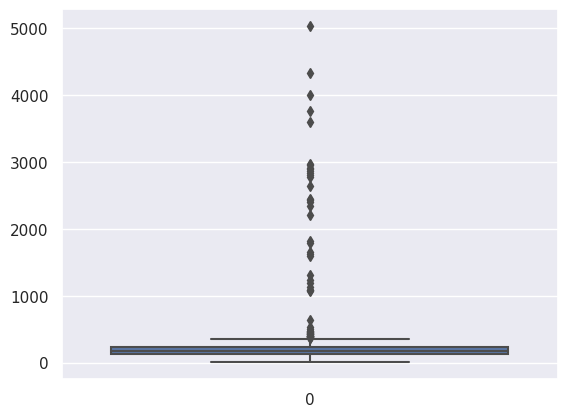

In [315]:
#checking for outliers
sns.boxplot(data['Consumption'])

In [316]:
#using Inner Quartile Range(IQR) to remove outliers

#calculation of upper and lower limits
Q1 = data['Consumption'].quantile(0.25)
Q3 = data['Consumption'].quantile(0.75)
IQR = Q3 - Q1
lower = Q1 - 1.5*IQR
upper = Q3 + 1.5*IQR

#arrays of boolean values indicating outlier rows
upper_arr = np.where(data['Consumption']>=upper)[0]
lower_arr = np.where(data['Consumption']<=lower)[0]

#removing the outliers
data.drop(index=upper_arr,inplace=True)
data.drop(index=lower_arr,inplace=True)

print("New shape:",data.shape)

New shape: (873, 5)


In [317]:
data.isnull().sum()

Consumption    0
ISOM           0
NFCCU          0
OFCCU          0
LTU            0
dtype: int64

### Splitting the data

In [318]:
#splittinf data into labels and target
X = data.loc[:, ['ISOM', 'NFCCU', 'OFCCU', 'LTU']]
y = data.iloc[:, 0]

print(X.shape, y.shape)

(873, 4) (873,)


In [319]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

## Model Creation

In [320]:
rf_reg = RandomForestRegressor()
rf_reg.fit(X_train, y_train)

RandomForestRegressor()

In [321]:
print('Model Performance on Training Set:', round(rf_reg.score(X_train, y_train)*100,2))
print('Model Performance on Test Set:', round(rf_reg.score(X_test, y_test)*100,2))

Model Performance on Training Set: 88.53
Model Performance on Test Set: 32.36


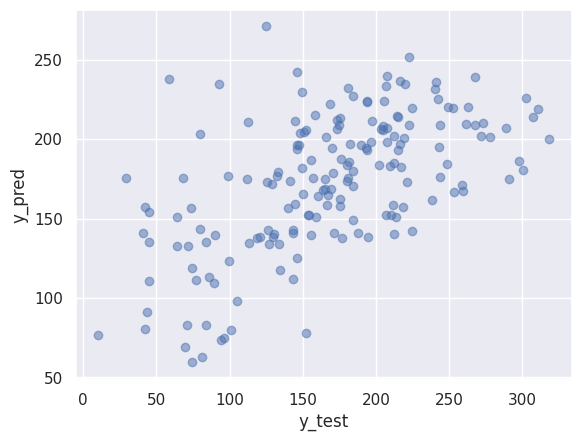

In [322]:
# Plot performance graph
y_pred = rf_reg.predict(X_test)
plt.scatter(y_test, y_pred, alpha = 0.5)
plt.xlabel("y_test")
plt.ylabel("y_pred")
plt.show()

In [323]:
# Model Error Values
print('MAE:', metrics.mean_absolute_error(y_test, y_pred))
print('MSE:', metrics.mean_squared_error(y_test, y_pred))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

MAE: 40.88287678181601
MSE: 2944.603173680501
RMSE: 54.26419789954055


In [324]:
print('Normalized RMSE ', round(np.sqrt(metrics.mean_squared_error(y_test, y_pred))/(max(y_test)-min(y_test)),2))
print('Max Value: ', max(y), '\nMin Value: ', min(y))

Normalized RMSE  0.18
Max Value:  357.472 
Min Value:  10.38


## Hyper Parameter Tuning

In [325]:
#Randomized Search CV
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 100, stop = 1200, num = 12)]
# Number of features to consider at every split
max_features = ['sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(5, 30, num = 6)]
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10, 15, 100]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 5, 10]

In [326]:
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf}

In [327]:
# Random search of parameters, using 5 fold cross validation,
# search across 100 different combinations
rf_random = RandomizedSearchCV(estimator = rf_reg, param_distributions = random_grid,
                               scoring='neg_mean_squared_error', n_iter = 10, cv = 5,
                               verbose=2, random_state=42, n_jobs = 1)

In [328]:
# Model Training with Hyperparameter Tuning
rf_random.fit(X_train,y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV] END max_depth=25, max_features=sqrt, min_samples_leaf=5, min_samples_split=15, n_estimators=1100; total time=   2.2s
[CV] END max_depth=25, max_features=sqrt, min_samples_leaf=5, min_samples_split=15, n_estimators=1100; total time=   2.0s
[CV] END max_depth=25, max_features=sqrt, min_samples_leaf=5, min_samples_split=15, n_estimators=1100; total time=   2.7s
[CV] END max_depth=25, max_features=sqrt, min_samples_leaf=5, min_samples_split=15, n_estimators=1100; total time=   3.0s
[CV] END max_depth=25, max_features=sqrt, min_samples_leaf=5, min_samples_split=15, n_estimators=1100; total time=   2.0s
[CV] END max_depth=20, max_features=sqrt, min_samples_leaf=5, min_samples_split=5, n_estimators=900; total time=   1.7s
[CV] END max_depth=20, max_features=sqrt, min_samples_leaf=5, min_samples_split=5, n_estimators=900; total time=   1.7s
[CV] END max_depth=20, max_features=sqrt, min_samples_leaf=5, min_samples_split=5, n_esti

RandomizedSearchCV(cv=5, estimator=RandomForestRegressor(), n_jobs=1,
                   param_distributions={'max_depth': [5, 10, 15, 20, 25, 30],
                                        'max_features': ['sqrt'],
                                        'min_samples_leaf': [1, 2, 5, 10],
                                        'min_samples_split': [2, 5, 10, 15,
                                                              100],
                                        'n_estimators': [100, 200, 300, 400,
                                                         500, 600, 700, 800,
                                                         900, 1000, 1100,
                                                         1200]},
                   random_state=42, scoring='neg_mean_squared_error',
                   verbose=2)

In [329]:
rf_random.best_params_

{'n_estimators': 1100,
 'min_samples_split': 15,
 'min_samples_leaf': 10,
 'max_features': 'sqrt',
 'max_depth': 10}

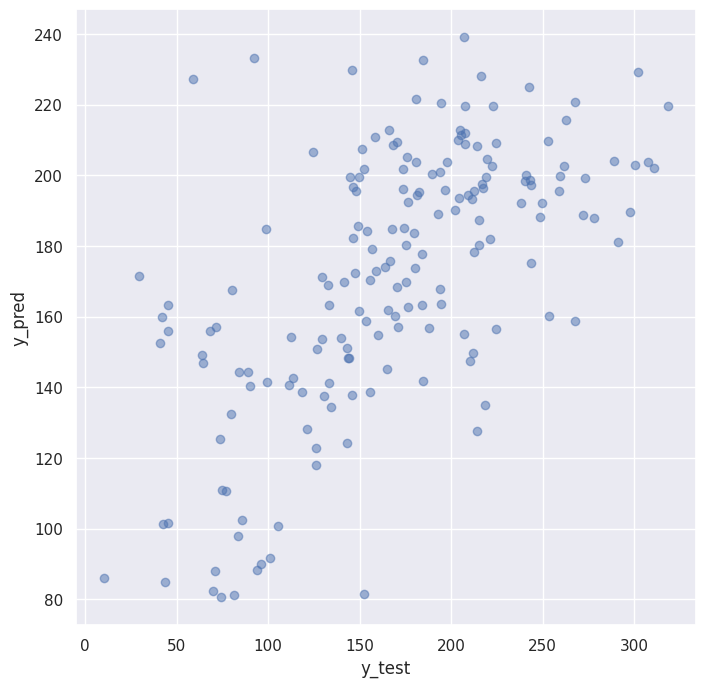

In [330]:
# Plot Performance Chart
prediction = rf_random.predict(X_test)
plt.figure(figsize = (8,8))
plt.scatter(y_test, prediction, alpha = 0.5)
plt.xlabel("y_test")
plt.ylabel("y_pred")
plt.show()

In [331]:
# RMSE/(max(DV)-min(DV))
print('R2 value: ', round(metrics.r2_score(y_test, prediction),2))
print('RMSE: ', round(np.sqrt(metrics.mean_squared_error(y_test, prediction)),2))
print('Normalized RMSE: ', round(np.sqrt(metrics.mean_squared_error(y_test, prediction))/(max(y_test)-min(y_test)),2))
print('Max Value: ', max(y_test), '\nMin Value: ', min(y_test))

R2 value:  0.38
RMSE:  51.86
Normalized RMSE:  0.17
Max Value:  318.488 
Min Value:  10.38


## Saving the Model

In [332]:
import pickle
# open a file, where you ant to store the data
file = open('consump_pred.pkl', 'wb')
# dump information to that file
pickle.dump(rf_random, file)
file.close()